In [31]:
import sys, os
sys.path.append(os.path.abspath(''))   # 把当前目录设为引用模块的地址之一

from utils import *
from data_utils import *
from models.solver_cnn import *
from models.ConvNet import *

import numpy as np
import pandas as pd
from itertools import product, permutations
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

# for auto-re00loading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Easily Profile Python Code in Jupyter
# install conda install line_profiler or pip install line-profiler
# see http://mortada.net/easily-profile-python-code-in-jupyter.html
%load_ext line_profiler

test_ctx()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
CPU or GPU? :  cpu(0)


In [3]:
GW_address = './data/'

data = pd.DataFrame(np.load(GW_address+'GW_H1.npy'), index=np.load(GW_address+'GW_H1_index.npy'))
print(data.shape)
peak_samppoint = data.values.argmax(axis=1)
peak_samppoint = int(peak_samppoint.sum() / peak_samppoint.shape[0])
peak_time = peak_samppoint/data.shape[-1]
peak_time = float('{:.2f}'.format(peak_time))
print('Peak sampling point at %dth (%.2fs).' %(peak_samppoint, peak_time))
data.head()
# 波形数据

(1249, 8192)
Peak sampling point at 7371th (0.90s).


,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
4.00|4.00,-9.812433e-23,-1.016813e-22,-1.049325e-22,-1.078680e-22,-1.104788e-22,-1.127572e-22,-1.146961e-22,-1.162896e-22,-1.175328e-22,-1.184220e-22,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4.00|4.40,-1.152648e-22,-1.178176e-22,-1.200368e-22,-1.219158e-22,-1.234493e-22,-1.246330e-22,-1.254633e-22,-1.259379e-22,-1.260552e-22,-1.258150e-22,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4.00|4.80,9.079569e-23,8.562824e-23,8.023045e-23,7.461677e-23,6.880222e-23,6.280235e-23,5.663323e-23,5.031138e-23,4.385375e-23,3.727764e-23,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4.00|5.20,-1.294046e-22,-1.266225e-22,-1.235170e-22,-1.200961e-22,-1.163684e-22,-1.123433e-22,-1.080311e-22,-1.034427e-22,-9.858974e-23,-9.348458e-23,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4.00|5.60,1.393361e-23,2.107371e-23,2.816331e-23,3.518515e-23,4.212210e-23,4.895727e-23,5.567399e-23,6.225586e-23,6.868683e-23,7.495120e-23,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


总波形数目： (1249,)
训练集波形数目： 600
测试集波形数目： 649


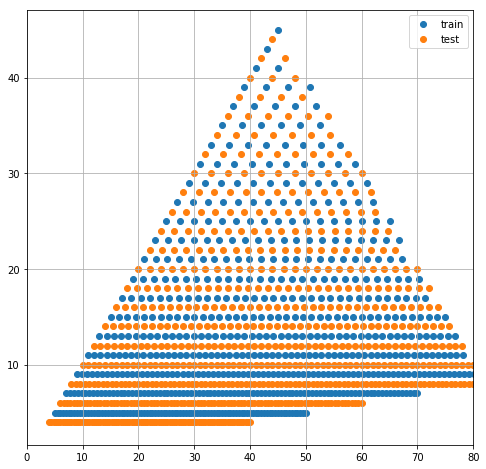

In [23]:
print('总波形数目：', data.index.shape)
train_masses = [(float(masses.split('|')[0]), float(masses.split('|')[1])) for masses in data.index if float(masses.split('|')[0]) % 2 != 0]
test_masses = [(float(masses.split('|')[0]), float(masses.split('|')[1])) for masses in data.index if float(masses.split('|')[0]) % 2 == 0]
print('训练集波形数目：', len(train_masses))
print('测试集波形数目：', len(test_masses))

train_m1, train_m2 = [ m[0] for m in train_masses],  [ m[1] for m in train_masses]
test_m1, test_m2 = [ m[0] for m in test_masses],  [ m[1] for m in test_masses]
plt.figure(figsize= (8,8))
plt.scatter(train_m2, train_m1, label='train')
plt.scatter(test_m2, test_m1, label = 'test')
plt.grid()
plt.legend()
plt.xlim(0,80)
# plt.title('训练集和测试集的波形在质量上的分布')
plt.show()

# 做好训练集和测试集的分割~

test_masses = [masses for masses in data.index if float(masses.split('|')[0]) % 2 == 0]
train_masses = [masses for masses in data.index if float(masses.split('|')[0]) % 2 != 0]
train_data = nd.array(data.loc[train_masses])
test_data = nd.array(data.loc[test_masses])

In [16]:
!ls data_evaluate/*best*

data_evaluate/snr_10_best_params_epoch@29.pkl
data_evaluate/snr_1_best_params_epoch@30.pkl
data_evaluate/snr_2_best_params_epoch@20.pkl
data_evaluate/snr_3_best_params_epoch@3.pkl
data_evaluate/snr_4_best_params_epoch@16.pkl
data_evaluate/snr_5_best_params_epoch@9.pkl
data_evaluate/snr_6_best_params_epoch@25.pkl
data_evaluate/snr_7_best_params_epoch@9.pkl
data_evaluate/snr_8_best_params_epoch@16.pkl
data_evaluate/snr_9_best_params_epoch@27.pkl


In [12]:
Info = {}
Info = {}
for snr in range(1,11):
    Info[snr] = nd.load('./data_evaluate/snr_%s_info.pkl' %snr)

Info[1].keys()

dict_keys(['lr_decay', 'lr_rate', 'batch_size', 'train_shift_list', 'test_shift_list', 'num_epoch', 'epoch', 'loss_history', 'loss_v_history', 'moving_loss_history', 'train_acc_history', 'test_acc_history'])

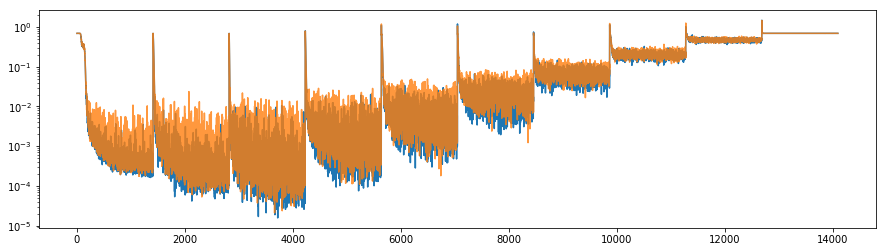

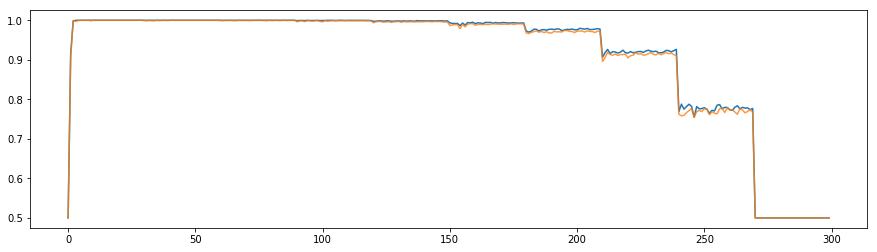

In [13]:
loss_history_list = []
loss_v_history_list = []
for snr in list(range(1,11))[::-1]:
    loss_history_list.extend(Info[snr]['loss_history'].asnumpy().tolist())
    loss_v_history_list.extend(Info[snr]['loss_v_history'].asnumpy().tolist())
    
plt.figure(figsize=(15,4))
plt.semilogy(loss_history_list, alpha = 1)
plt.semilogy(loss_v_history_list, alpha = 0.8)
plt.show()

train_acc_history_list = []
test_acc_history_list = []
for snr in list(range(1,11))[::-1]:
    train_acc_history_list.extend(Info[snr]['train_acc_history'].asnumpy().tolist())
    test_acc_history_list.extend(Info[snr]['test_acc_history'].asnumpy().tolist())
    
plt.figure(figsize=(15,4))
plt.plot(train_acc_history_list, alpha = 1)
plt.plot(test_acc_history_list, alpha = 0.8)
plt.show()

In [26]:
params_add = ['data_evaluate/snr_10_best_params_epoch@29.pkl',
 'data_evaluate/snr_1_best_params_epoch@30.pkl',
 'data_evaluate/snr_2_best_params_epoch@20.pkl',
 'data_evaluate/snr_3_best_params_epoch@3.pkl',
 'data_evaluate/snr_4_best_params_epoch@16.pkl',
 'data_evaluate/snr_5_best_params_epoch@9.pkl',
 'data_evaluate/snr_6_best_params_epoch@25.pkl',
 'data_evaluate/snr_7_best_params_epoch@9.pkl',
 'data_evaluate/snr_8_best_params_epoch@16.pkl',
 'data_evaluate/snr_9_best_params_epoch@27.pkl']

In [39]:
auc_frame = []
for param_add in params_add[:3]:
    param = nd.load(param_add)
    
    OURS_ori = ConvNet(conv_params = {'kernel': ((1,16), (1,8), (1,8)), 
                                        'num_filter': (16, 32, 64,),
                                        'stride': ((1,1), (1,1), (1,1),),
                                        'padding': ((0,0), (0,0), (0,0),),
                                        'dilate': ((1,1), (1,1), (1,1),)},
                       act_params = {'act_type': ('relu', 'relu', 'relu', 'relu',)},
                       pool_params = {'pool_type': ('avg', 'avg', 'avg',),
                                        'kernel': ((1,16), (1,16), (1,16),),
                                        'stride': ((1,2), (1,2), (1,2),),
                                        'padding': ((0,0),(0,0), (0,0),),
                                        'dilate': ((1,1), (1,1), (1,1),)},
                       fc_params = {'hidden_dim': (64,)}, drop_prob = 0, 
                       params_inits = param,
                       input_dim = (1,1,8192)
                      )
    auc_list = []
    for snr in np.linspace(0.1, 1, 10)[::3]:
        Solver = Solver_nd(model = OURS_ori, 
                           train = train_data[:10],
                           test = test_data[:10],
                           SNR = snr, 
                           batch_size = 32)
        auc_var_list = []
        for i in range(10):
            prob, label, _= Solver.predict_nd()
            fpr, tpr, thresholds = metrics.roc_curve(label, prob, pos_label=1)
            auc_var_list.append(metrics.auc(fpr, tpr))
            if i == 9: break

        auc_list.append(auc_var_list)
    auc_frame.append(auc_list)
# np.save('./images/auc_finite_noise_SNR=1', auc_list)

SNR = 0.1
Label for training: (200,)
Label for testing: (200,)
SNR = 0.4
Label for training: (200,)
Label for testing: (200,)
SNR = 0.7
Label for training: (200,)
Label for testing: (200,)
SNR = 1.0
Label for training: (200,)
Label for testing: (200,)
SNR = 0.1
Label for training: (200,)
Label for testing: (200,)
SNR = 0.4
Label for training: (200,)
Label for testing: (200,)
SNR = 0.7
Label for training: (200,)
Label for testing: (200,)
SNR = 1.0
Label for training: (200,)
Label for testing: (200,)
SNR = 0.1
Label for training: (200,)
Label for testing: (200,)
SNR = 0.4
Label for training: (200,)
Label for testing: (200,)
SNR = 0.7
Label for training: (200,)
Label for testing: (200,)
SNR = 1.0
Label for training: (200,)
Label for testing: (200,)


In [80]:
pretrained_add = './data_evaluate/'
os.system('ls -a %s | grep best > test.txt' %pretrained_add)
tt = pd.read_csv('./test.txt', header=None)
os.system('rm test.txt')
tt['snr'] = tt[0].map(lambda x: int(x.split('_')[1]))
tt = tt.sort_values('snr', ascending=False)[0].values.tolist()

In [84]:
tt[0].split('_')[1]

'10'

In [82]:
nd.load(pretrained_add + tt[0]).keys()

dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4', 'W5', 'b5'])

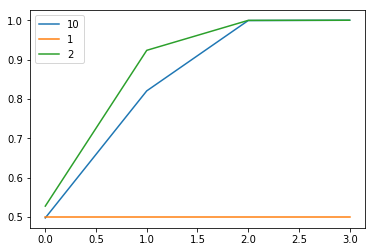

In [57]:
for i, model in enumerate(list([10,1,2])):
    plt.plot(auc_frame_array[i].mean(axis=1), label = model)
plt.legend()

In [51]:
auc_frame_array[0].mean(axis=1)

array([ 0.49769,  0.82054,  0.99926,  1.     ])